# HR-аналитика компании.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import os
import phik

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import(
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from optuna import distributions
from optuna.integration import OptunaSearchCV

RANDOM_STATE = 42
TEST_SIZE = 0.25

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

## Задача.

### Шаг. Загрузка данных для первой задачи

In [5]:
path1 = '/datasets/train_job_satisfaction_rate.csv'
path2 = 'C:/Users/Kseno/Downloads/train_job_satisfaction_rate.csv'

if os.path.exists(path1):
    train_job = pd.read_csv(path1, index_col = 'id')
elif os.path.exists(path2):
    train_job = pd.read_csv(path2, index_col = 'id')
else:
    print('Что-то пошло не так')

In [6]:
train_job.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [7]:
train_job.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [8]:
train_job.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441


In [9]:
train_job.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


* в датафрейме `train_job` содержится 9 столбцов и 4000 строк;
* данные соответсвуют описанию;
* в данных есть пропуски;
* типы данных верные.

In [11]:
path1 = '/datasets/test_features.csv'
path2 = 'C:/Users/Kseno/Downloads/test_features.csv'

if os.path.exists(path1):
    test_features = pd.read_csv(path1, index_col = 'id')
elif os.path.exists(path2):
    test_features = pd.read_csv(path2, index_col = 'id')
else:
    print('Что-то пошло не так')

In [12]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [13]:
test_features.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [14]:
test_features.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,1998,1999,2000,2000,2000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


In [15]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


* в датафрейме `test_features` содержится 8 столбцов и 2000 строк;
* в данных есть пропуски;
* данные соответствуют описанию;
* типы данных верные.

In [17]:
path1 = '/datasets/test_target_job_satisfaction_rate.csv'
path2 = 'C:/Users/Kseno/Downloads/test_target_job_satisfaction_rate.csv'

if os.path.exists(path1):
    target_job = pd.read_csv(path1, index_col = 'id')
elif os.path.exists(path2):
    target_job = pd.read_csv(path2, index_col = 'id')
else:
    print('Что-то пошло не так')

In [18]:
target_job.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


In [19]:
target_job.describe()

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


In [20]:
target_job.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


* в датафрейме `target_job` содежится один столбец и 2000 строк;
* пропусков в данных нет;
* тип данных верный.

**Итоги раздела:**
1. В датафрейме `train_job` содержится 9 столбцов и 4000 строк, в данных есть пропуски, типы данных верные.
2. В датафрейме `test_features` содержится 8 столбцов и 2000 строк, в данных есть пропуски, типы данных верные.
3. В датафрейме `target_job` содежится один столбец и 2000 строк, пропусков в данных нет, тип данных верный.

### Шаг. Предобработка данных.

In [24]:
# Проверка на пропуски и ошибки в данных
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [25]:
# Замена пустого значения
test_features['dept'] = test_features['dept'].replace(' ', np.nan)

In [26]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [27]:
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

In [28]:
# Соединение таблиц для удобства обработки и исследования
test_job = test_features.join(target_job, on='id')
test_job

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.56
109582,technology,middle,low,3,no,no,2,21600,0.14
305653,technology,junior,low,1,no,no,3,14400,0.11


**Итоги раздела:**
1. Датафреймы `train_job`, `test_features` и `target_job` были объединены в один общий `all_df` для удоства исследлвания и обработки.
2. Пустые значения признаков в столбцах `dept` и `workload` были заменены на NaN.
3. Пропуски в данных были заполнены в пайплайне, в категориальных признаках - модой, в количественных - медианой.

### Шаг. Исследовательский анализ данных

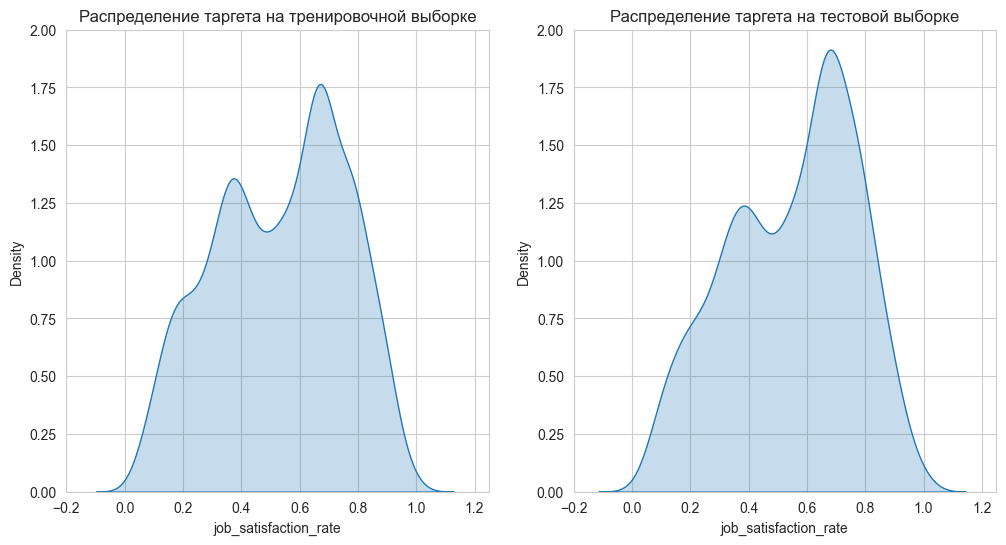

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.kdeplot(x='job_satisfaction_rate', data=train_job, fill=True, ax=axes[0])
axes[0].set_title('Распределение таргета на тренировочной выборке')
axes[0].set_xlim(-0.2, 1.25)
axes[0].set_ylim(0, 2)

sns.kdeplot(x='job_satisfaction_rate', data=target_job, fill=True, ax=axes[1])
axes[1].set_title('Распределение таргета на тестовой выборке')
axes[1].set_xlim(-0.2, 1.25)
axes[1].set_ylim(0, 2)

plt.show()

Распределение неравномерное, есть два пика в районе 0.4 и 0.7. В целом данные в тренировочной и тестовой выборках схожие.

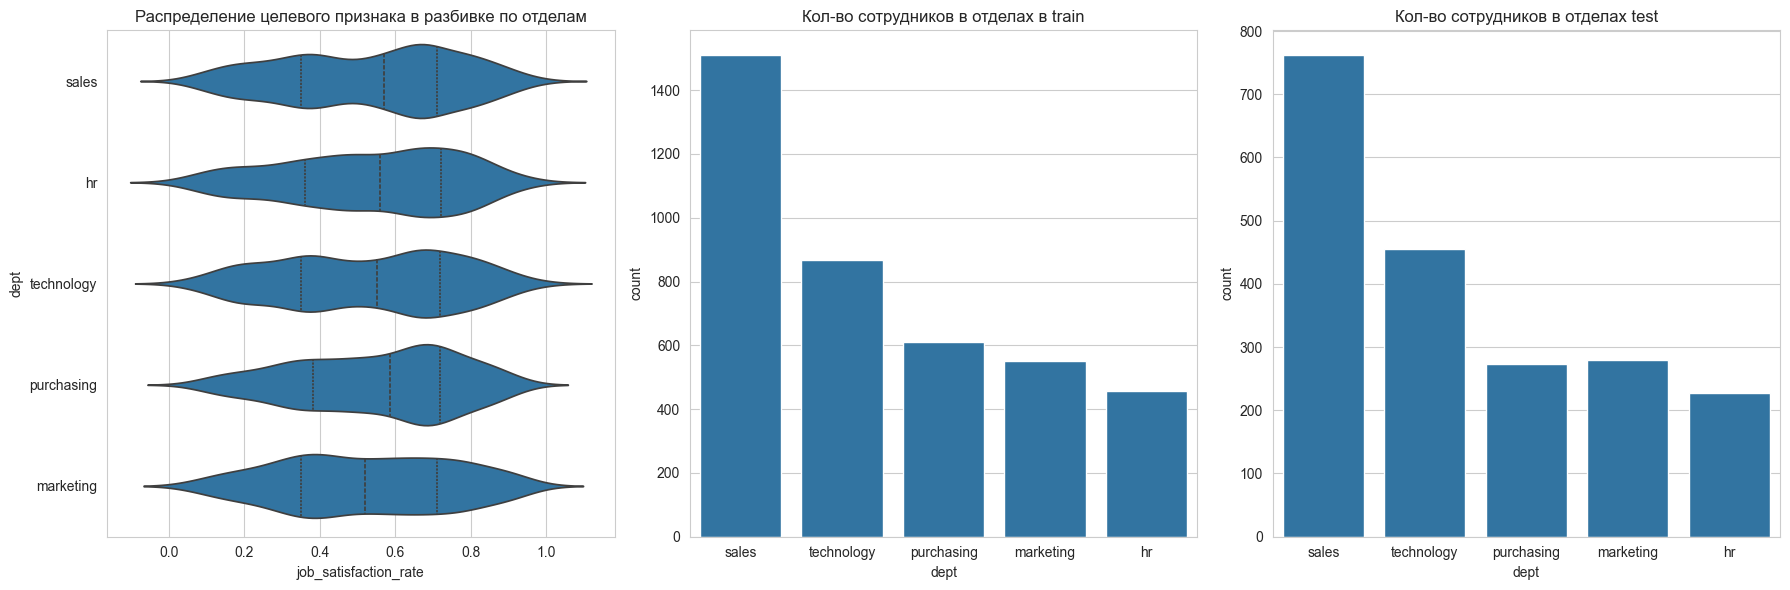

In [33]:
dept_order = ['sales', 'technology', 'purchasing', 'marketing', 'hr']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.violinplot(y='dept', x='job_satisfaction_rate', inner="quartile", orient="h", data=train_job, ax=axes[0])
axes[0].set_title('Распределение целевого признака в разбивке по отделам')

sns.countplot(x='dept', data=train_job, order=dept_order, ax=axes[1])
axes[1].set_title('Кол-во сотрудников в отделах в train')

sns.countplot(data=test_features, x='dept', order=dept_order, ax=axes[2])
axes[2].set_title('Кол-во сотрудников в отделах test')

plt.tight_layout()
plt.show()

Показатели целевого признака примерно одинаковы в любом отделе компании. Самый крупный отдел - `Sales`, самый малочисленный - `HR`. Данные в тренировочной и тестовой выборках имеют схожее распределение.

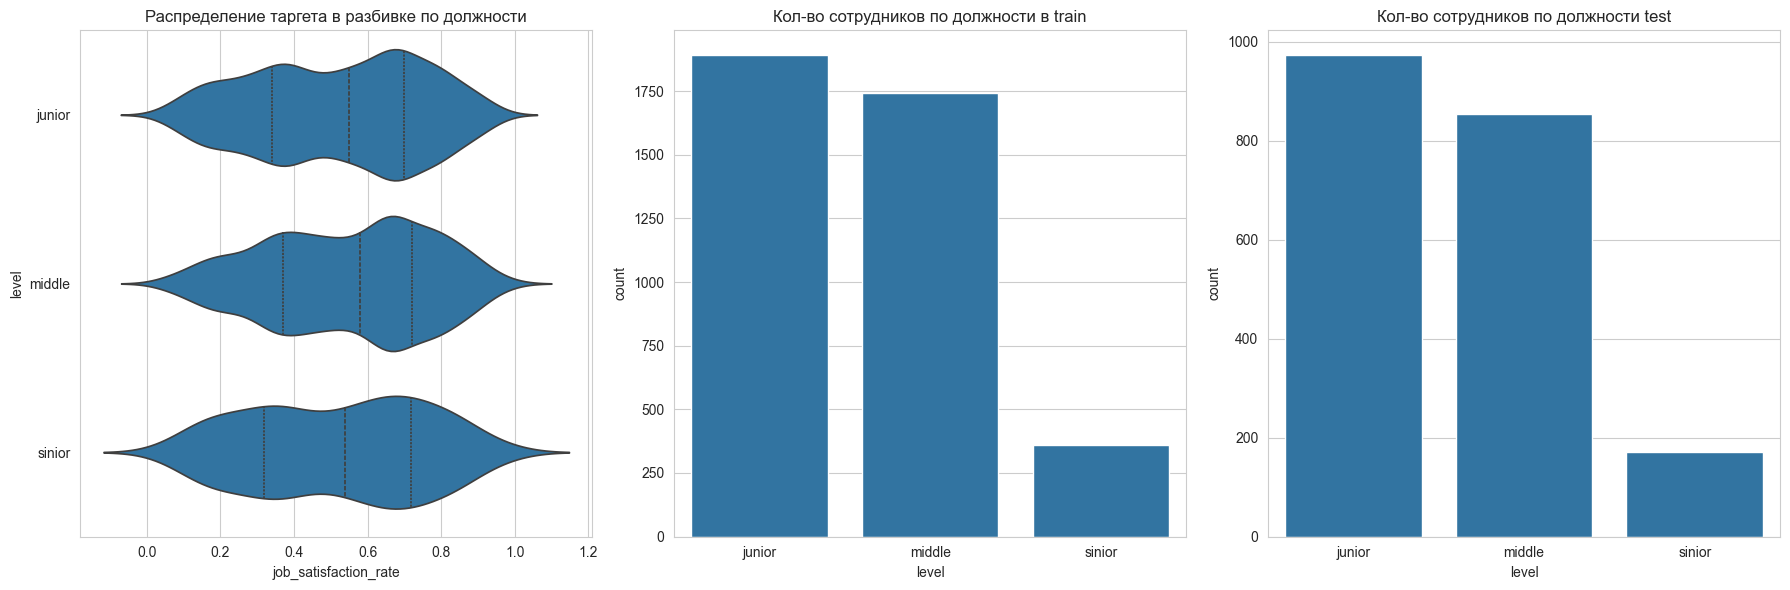

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.violinplot(y='level', x='job_satisfaction_rate', inner="quartile", orient="h", data=train_job, ax=axes[0])
axes[0].set_title('Распределение таргета в разбивке по должности')

sns.countplot(x='level', data=train_job, ax=axes[1])
axes[1].set_title('Кол-во сотрудников по должности в train')

sns.countplot(data=test_features, x='level', ax=axes[2])
axes[2].set_title('Кол-во сотрудников по должности test')

plt.tight_layout()
plt.show()

Уровень занимаемой должности так же не оказывает влияния на целевой признак. Больше всего в компании начинающих специалистов. В целом данные в тренировочной и тестовой выборках схожие.

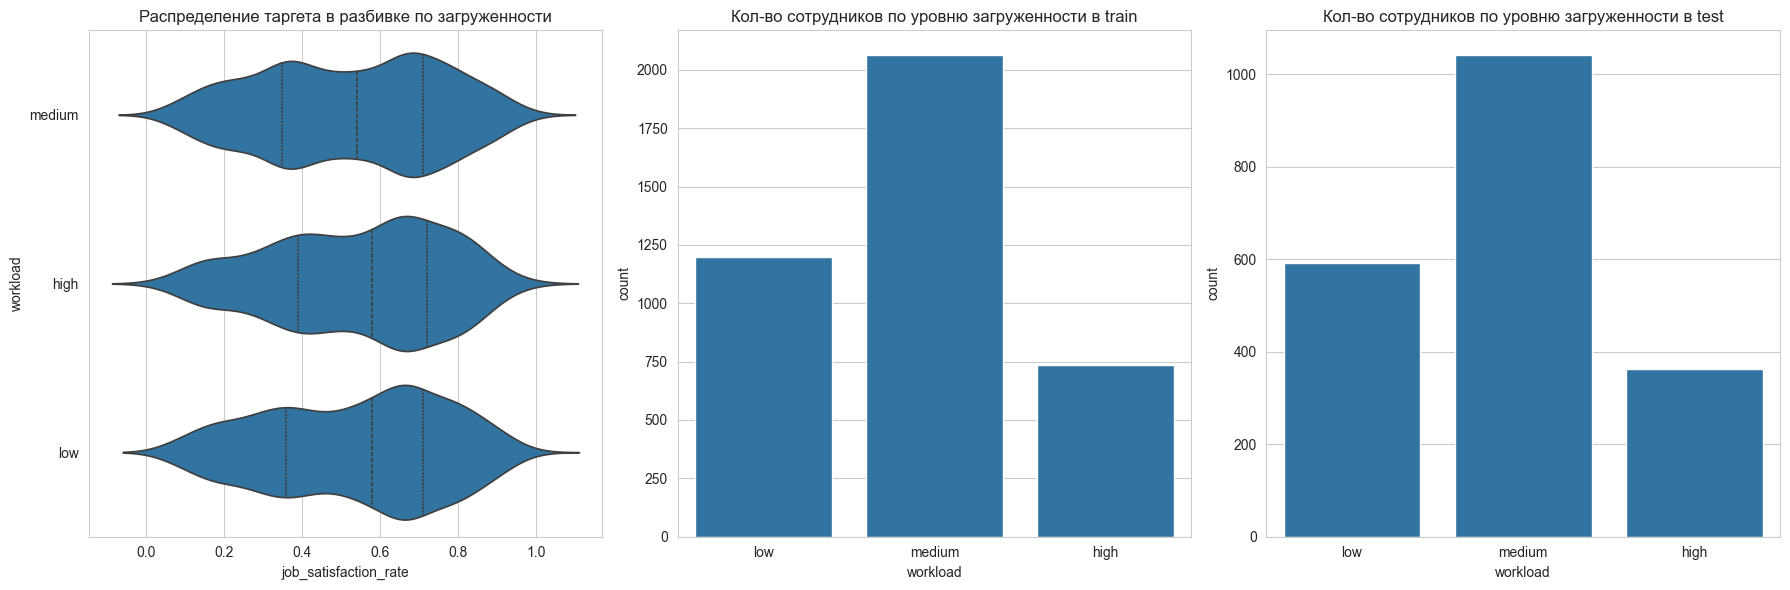

In [37]:
work_order=['low', 'medium', 'high']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.violinplot(y='workload', x='job_satisfaction_rate', inner="quartile", orient="h", data=train_job, ax=axes[0])
axes[0].set_title('Распределение таргета в разбивке по загруженности')

sns.countplot(x='workload', data=train_job, order=work_order, ax=axes[1])
axes[1].set_title('Кол-во сотрудников по уровню загруженности в train')

sns.countplot(data=test_features, x='workload', order=work_order, ax=axes[2])
axes[2].set_title('Кол-во сотрудников по уровню загруженности в test')

plt.tight_layout()
plt.show()

Распределение целевого признака по категориям загруженности сотрудника так же равномерное. В основном сотрудники компании загружены Средне. Данные в тренировочной и тестовой выборках схожие.

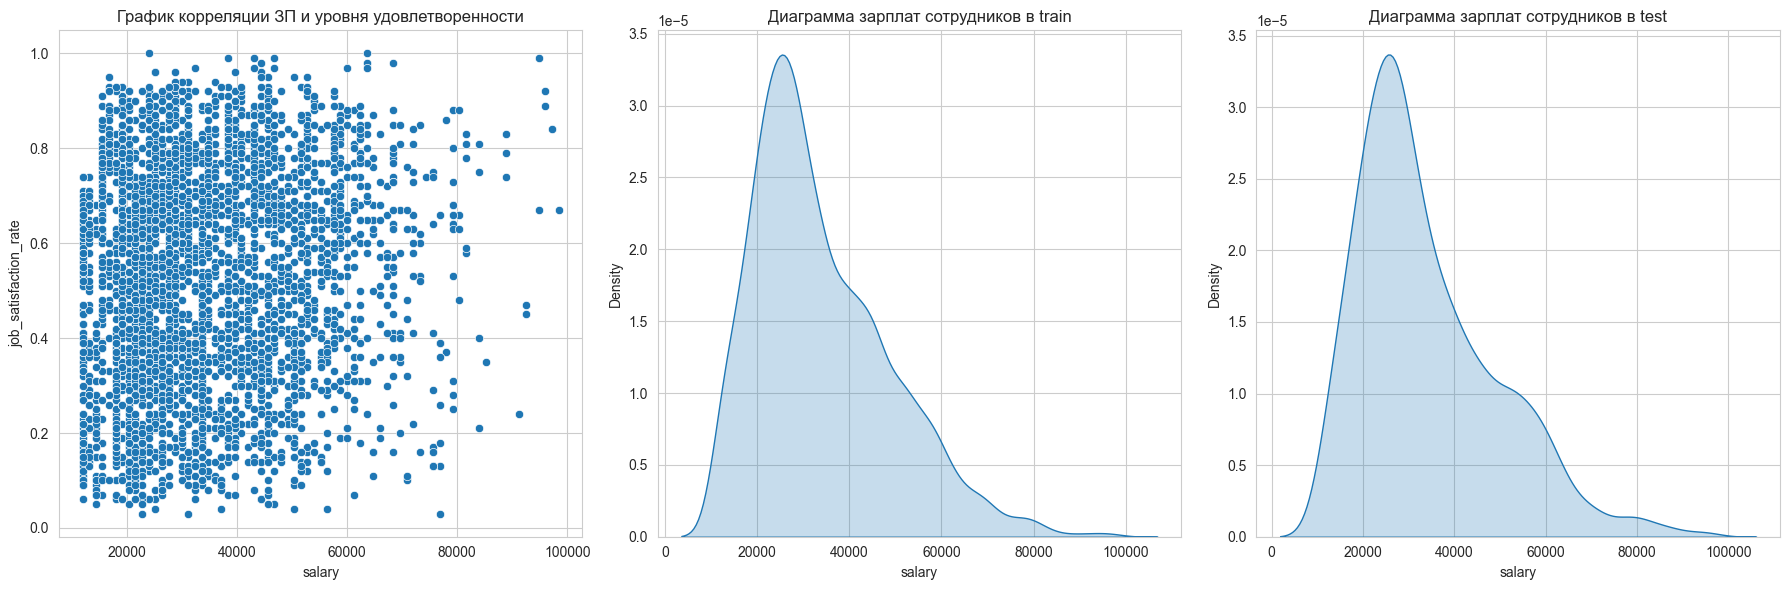

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.scatterplot(x='salary', y='job_satisfaction_rate', data=train_job, ax=axes[0])
axes[0].set_title('График корреляции ЗП и уровня удовлетворенности')

sns.kdeplot(x='salary', fill=True, data=train_job, ax=axes[1])
axes[1].set_title('Диаграмма зарплат сотрудников в train')

sns.kdeplot(x='salary', fill=True, data=test_features, ax=axes[2])
axes[2].set_title('Диаграмма зарплат сотрудников в test')

plt.tight_layout()
plt.show()

В целом можно проследить слабую тенденцию между ростом заработной платы и ростом удовлетворённости сотрудника. Самый популярный размер заработной платы в компании в районе 30 000. Данные в тренировочной и тестовой выборках схожие.

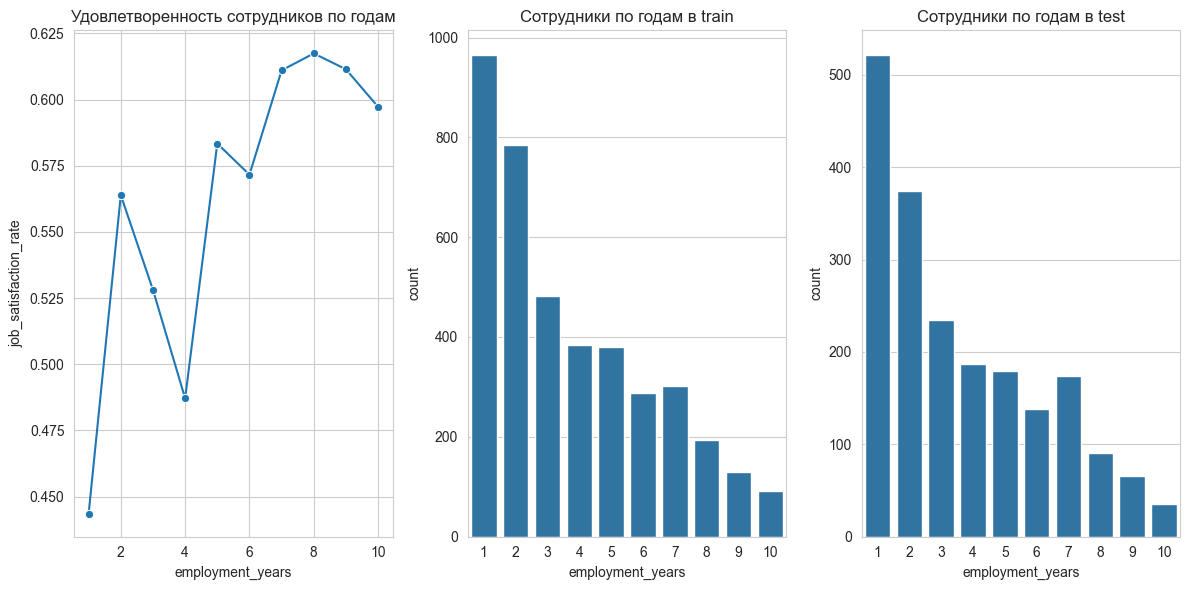

In [41]:
employment_years_group = train_job.pivot_table(index='employment_years', values='job_satisfaction_rate')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

sns.lineplot(data=employment_years_group, x='employment_years', y='job_satisfaction_rate', marker='o', ax=axes[0])
axes[0].set_title('Удовлетворенность сотрудников по годам')

sns.countplot(x='employment_years', data=train_job, ax=axes[1])
axes[1].set_title('Сотрудники по годам в train')

sns.countplot(data=test_features, x='employment_years', ax=axes[2])
axes[2].set_title('Сотрудники по годам в test')

plt.tight_layout()
plt.show()

Уровень удовлетворенности сотрудников резко проседает на 3, 4, 6 и 10 годах работы. Больше всего в компании сотрудников, которые работают 1 и 2 года. Данные в тренировочной и тестовой выборках схожие.

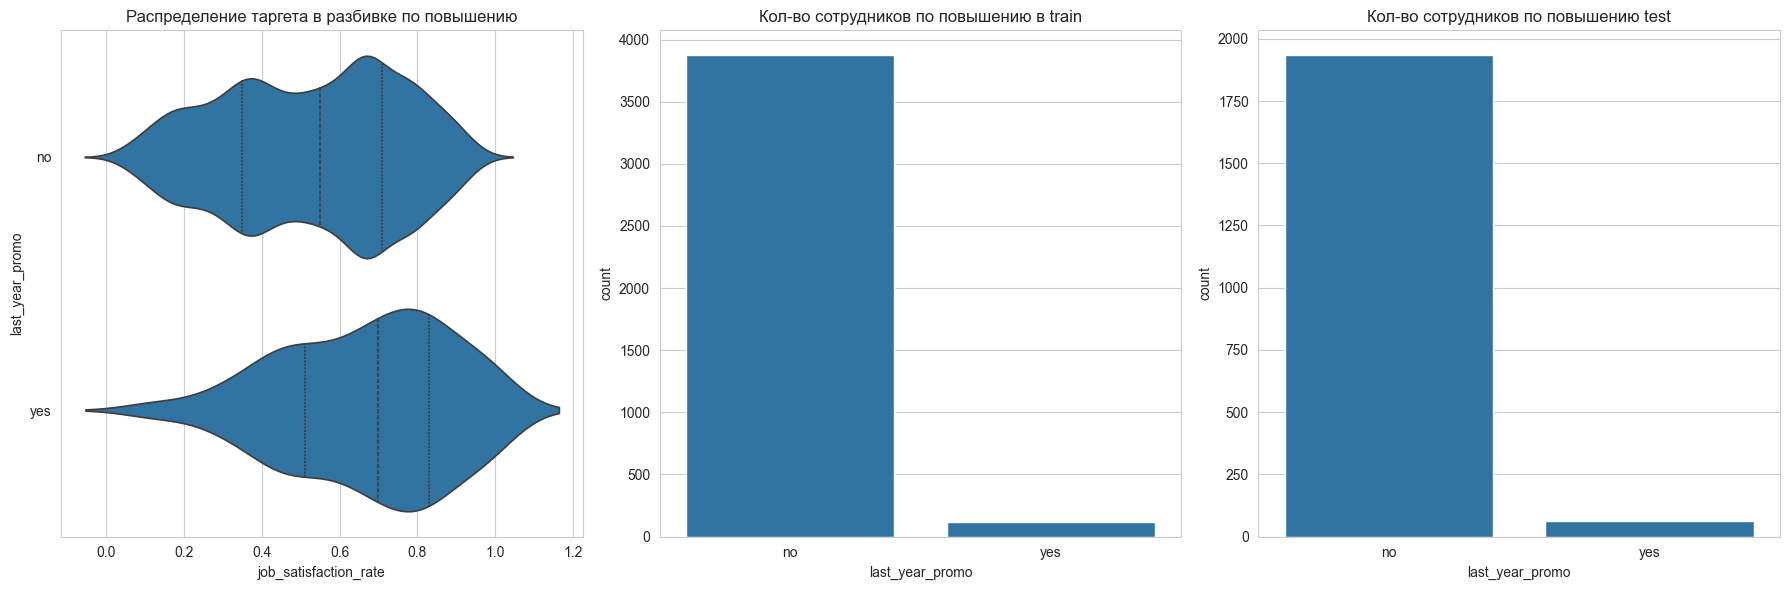

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.violinplot(y='last_year_promo', x='job_satisfaction_rate', inner="quartile", orient="h", data=train_job, ax=axes[0])
axes[0].set_title('Распределение таргета в разбивке по повышению')

sns.countplot(x='last_year_promo', data=train_job, ax=axes[1])
axes[1].set_title('Кол-во сотрудников по повышению в train')

sns.countplot(data=test_features, x='last_year_promo', ax=axes[2])
axes[2].set_title('Кол-во сотрудников по повышению test')

plt.tight_layout()
plt.show()

У работиков с повышением за последний год уровень удовлетворенности значительно выше чем у тех, у кого его не было. Но при этом доля работников с повышением ничтожно мала. Данные в тренировочной и тестовой выборках схожие.

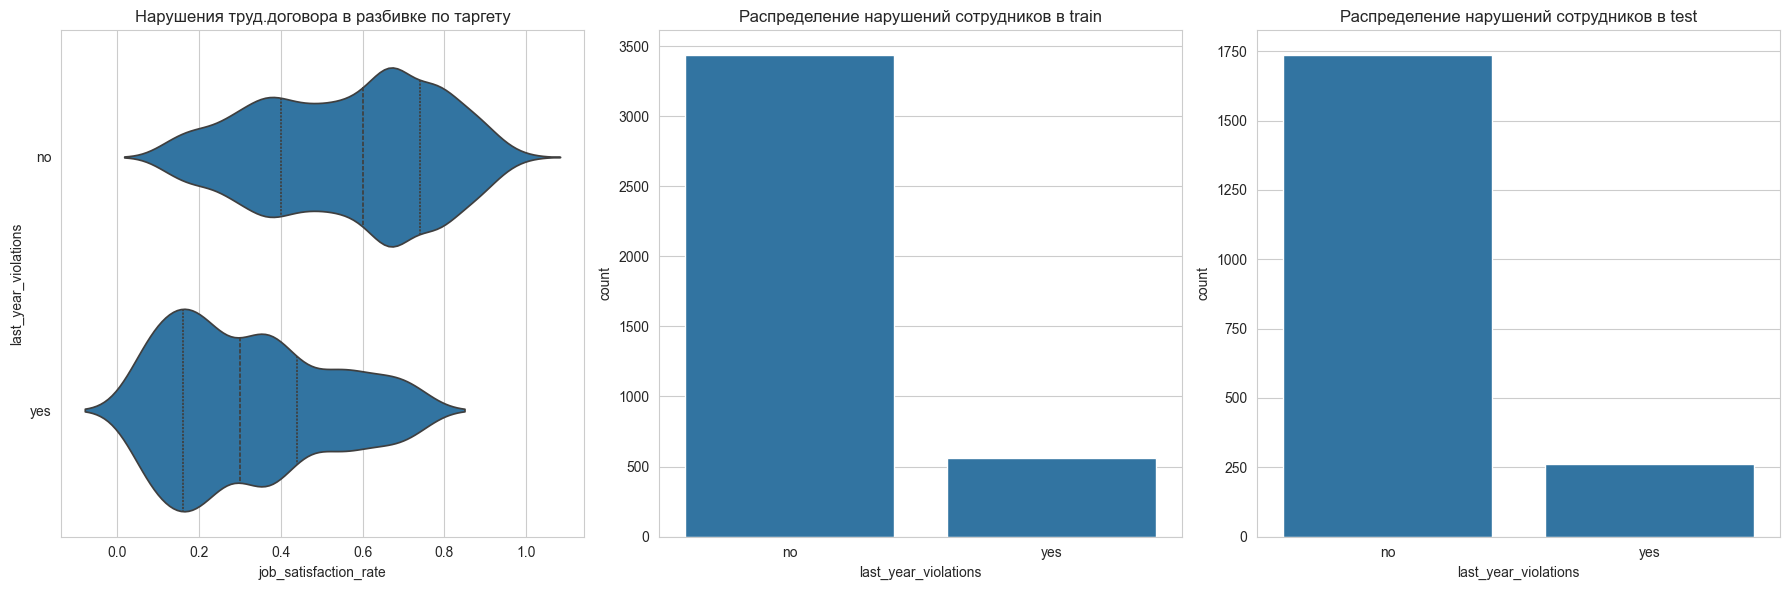

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.violinplot(y='last_year_violations', x='job_satisfaction_rate', inner="quartile", orient="h", data=train_job, ax=axes[0])
axes[0].set_title('Нарушения труд.договора в разбивке по таргету')

sns.countplot(x='last_year_violations', data=train_job, ax=axes[1])
axes[1].set_title('Распределение нарушений сотрудников в train')

sns.countplot(data=test_features, x='last_year_violations', ax=axes[2])
axes[2].set_title('Распределение нарушений сотрудников в test')

plt.tight_layout()
plt.show()

У сотрудников, нарушивших трудовой договор уровень удовлетворенности значительно меньше чем у тех, кто этого не делал. В компании мало нарушителей. Данные в тренировочной и тестовой выборках схожие.

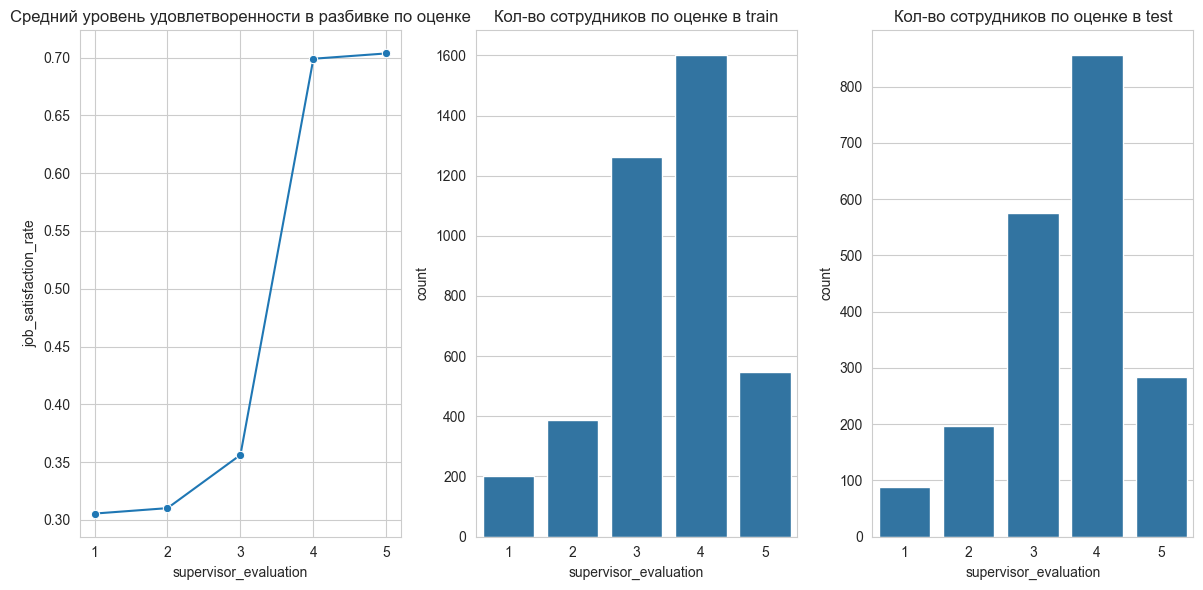

In [47]:
supervisor_evaluation_group = train_job.pivot_table(index='supervisor_evaluation', values='job_satisfaction_rate')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

sns.lineplot(data=supervisor_evaluation_group, x='supervisor_evaluation', y='job_satisfaction_rate', marker='o', ax=axes[0])
axes[0].set_title('Средний уровень удовлетворенности в разбивке по оценке')

sns.countplot(x='supervisor_evaluation', data=train_job, ax=axes[1])
axes[1].set_title('Кол-во сотрудников по оценке в train')

sns.countplot(x='supervisor_evaluation', data=test_features, ax=axes[2])
axes[2].set_title('Кол-во сотрудников по оценке в test')


plt.tight_layout()
plt.show()

Высокий уровень удволетворенности имеют только сотрудники с оценками 4 и 5. При этом в компании преобладают оценки 3 и 4. Данные в тренировочной и тестовой выборках схожие.

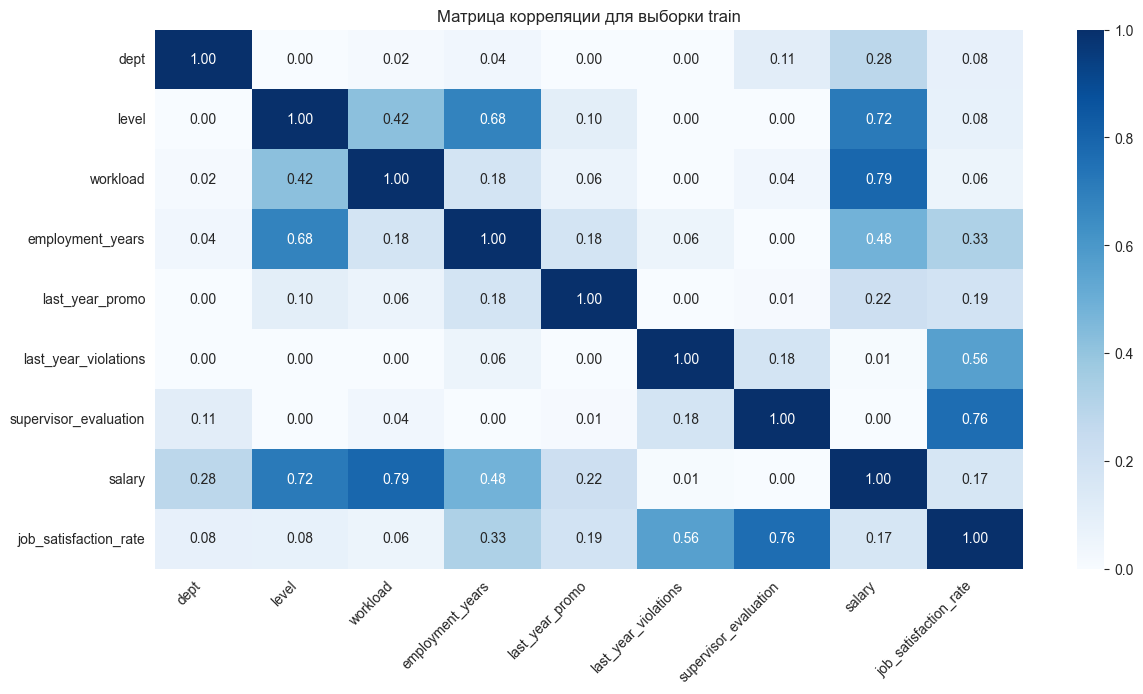

In [49]:
corr_train = train_job.phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
plt.figure(figsize=(14,7))
heatmap = sns.heatmap(corr_train, annot=True, cmap='Blues', fmt='.2f')
plt.title('Матрица корреляции для выборки train')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.show()

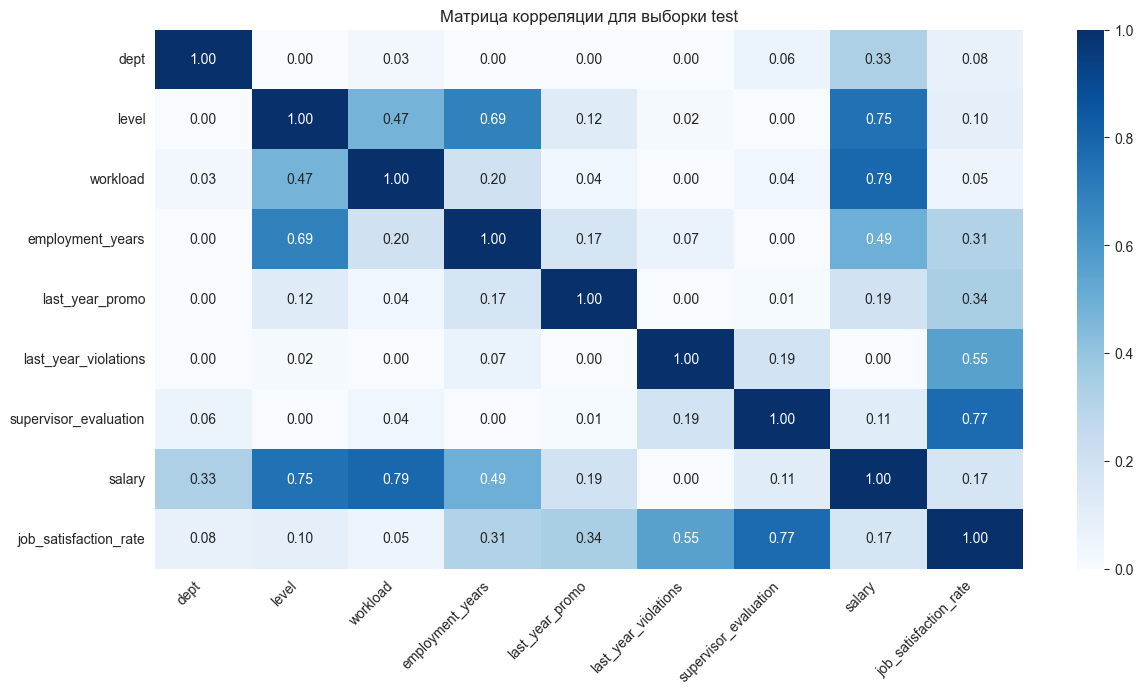

In [50]:
corr_test = test_job.phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
plt.figure(figsize=(14,7))
heatmap = sns.heatmap(corr_test, annot=True, cmap='Blues', fmt='.2f')
plt.title('Матрица корреляции для выборки test')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.show()

Целевой признак `job_satisfaction_rate` слабо коррелирует со входными признаками. Между признаками `Salary`, `Level` и `Workload` есть сильная корреляция, но порог мультиколлинеарности 0.9, значит признаки можно оставить.

**Итоги раздела:**
1. Распределение целевого признака имеет два пика в районе 0.4 и 0.7.
2. Целевой признак имеет равномерное распределение между входными признаками: `Dept`, `Level`, `Workload`.
3. Работники с высокой заработной платой имеют высокий уровень удовлетворенности.
4. Уровень удовлетворенности сотрудников резко проседает на 3, 4, 6 и 10 годах работы. 
5. У работников, имевших повышение, более высокий уровень удовлетворенности.
6. Нарушение трудового договора негативно сказывается на уровне удволетворенности сотрудника.
7. Работники с оценками 4 и 5 имеют более выской уровень удовлетворенности.
8. Была построена матрица корреляции между всеми признаками.
9. Целевой признак `job_satisfaction_rate` слабо коррелирует со входными признаками.
10. Мультиколлинеарности между признаками нет.
11. Данные в тестовой и тренировочной выборках распределены примерно одинаково.

### Шаг. Подготовка данных

In [54]:
# Дополнение пайплайна для заполнения пропусков кодированием признаков
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

ohe_pipe = Pipeline(
    [(
        'simpleImputer',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ohe',
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    )]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['no', 'yes']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median'))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

**Итоги раздела:**
1. Пайпалйн предобработки был дополнен кодированием признаков с помощью кодировщиков `OneHotEncoder` и `OrdinalEncoder`.

### Шаг. Обучение моделей

In [57]:
def smape(y_true, y_pred):
    n = len(y_true)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    summ = np.sum(numerator / denominator)
    smape_value = summ * (100 / n)
    return smape_value

smape_score = make_scorer(smape, greater_is_better=False)

In [58]:
# Финальный пайплайн с перебором моделей и гиперпараметров для задачи регрессии
X_train = train_job.drop('job_satisfaction_rate', axis=1)
X_test = test_job.drop('job_satisfaction_rate', axis=1)
y_train = train_job['job_satisfaction_rate']
y_test = test_job['job_satisfaction_rate']

final_pipeline = Pipeline([
    ('data_preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 10),
        'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [LinearRegression()],
        'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [SVR()],
        'models__C': range(1, 5),
        'models__gamma': range(1, 5),
        'data_preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    
]

randomized_search = RandomizedSearchCV(
    final_pipeline,
    param_grid,
    cv=10,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('data_preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord...
                                         'models__n_neighbors': range(2, 10)},
                                        {'data_preprocessor__num': [StandardScaler(),
                                                                    MinMaxScaler(),
                                                                    'passthrough'],
                                         'models': [LinearRegression()]},
                                        {'data_preprocessor__num': [StandardScaler(),
                                                                    MinMaxScaler(),
                                                                    'passthrough'],
                                         'models': [SVR()],
                                         'models__C': range(1, 5),
                                         'models__gamma': range(1, 5)}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [59]:
best_model = randomized_search.best_estimator_
'Метрика лучшей модели на кросс-валидации:', -randomized_search.best_score_

('Метрика лучшей модели на кросс-валидации:', 14.956167257087293)

In [60]:
'Лучшая модель и её параметры:', best_model

('Лучшая модель и её параметры:',
 Pipeline(steps=[('data_preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('ohe',
                                                   Pipeline(steps=[('simpleImputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('ohe',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknown='ignore',
                                                                                  sparse_output=False))]),
                                                   ['dept']),
                                                  ('ord',
                                                   Pipeline(steps=[('simpleImputer_before_ord',
            

In [61]:
f'Метрика SMAPE на тестовой выборке: {smape(y_test, best_model.predict(X_test))}'

'Метрика SMAPE на тестовой выборке: 14.302367275824402'

In [62]:
# Результаты работы пайплайна и перебора гиперпараметров моделей
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
0,1,DecisionTreeRegressor(random_state=42),-14.956167,"{'models__max_features': 16, 'models__max_dept..."
6,2,DecisionTreeRegressor(random_state=42),-15.159981,"{'models__max_features': 9, 'models__max_depth..."
3,3,DecisionTreeRegressor(random_state=42),-16.012117,"{'models__max_features': 18, 'models__max_dept..."
2,4,DecisionTreeRegressor(random_state=42),-16.729405,"{'models__max_features': 15, 'models__max_dept..."
8,4,DecisionTreeRegressor(random_state=42),-16.729405,"{'models__max_features': 15, 'models__max_dept..."
7,6,DecisionTreeRegressor(random_state=42),-16.967456,"{'models__max_features': 6, 'models__max_depth..."
5,7,DecisionTreeRegressor(random_state=42),-18.588843,"{'models__max_features': 17, 'models__max_dept..."
9,8,DecisionTreeRegressor(random_state=42),-23.736673,"{'models__max_features': 3, 'models__max_depth..."
4,9,DecisionTreeRegressor(random_state=42),-24.321936,"{'models__max_features': 8, 'models__max_depth..."
1,10,SVR(),-27.290715,"{'models__gamma': 2, 'models__C': 4, 'models':..."


**Итоги раздела:**
1. Создана собственная функция `SMAPE`, которая рассчитывает симметричное среднее абсолютное процентное отклонение.
2. Пайплайн был дополнен 4 моделями и несколькими гиперпараметрами.
3. Лучшей оказалась модель `DecisionTreeRegressor` с гиперпараетрами `max_depth=13`, `max_features=16`.
4. Метрика SMAPE лучшей модели на кросс-валидации 14.96, на тестовой выборке 14.3.

## Задача.

### Шаг. Загрузка данных

In [66]:
path1 = '/datasets/train_quit.csv'
path2 = 'C:/Users/Kseno/Downloads/train_quit.csv'

if os.path.exists(path1):
    train_quit = pd.read_csv(path1, index_col = 'id')
elif os.path.exists(path2):
    train_quit = pd.read_csv(path2, index_col = 'id')
else:
    print('Что-то пошло не так')

In [67]:
train_quit.describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [68]:
train_quit.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations,quit
count,4000,4000,4000,4000,4000,4000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,1438,1949,2118,3887,3455,2872


In [69]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


* в датафрейме `train_quit` 9 столбцов и 4000 строк;
* данные соответствуют описанию;
* пропусков в данных нет;
* типы данных верные.

In [71]:
path1 = '/datasets/test_target_quit.csv'
path2 = 'C:/Users/Kseno/Downloads/test_target_quit.csv'

if os.path.exists(path1):
    target_quit = pd.read_csv(path1, index_col = 'id')
elif os.path.exists(path2):
    target_quit = pd.read_csv(path2, index_col = 'id')
else:
    print('Что-то пошло не так')

In [72]:
target_quit.describe()

,quit
count,2000
unique,2
top,no
freq,1436


In [73]:
target_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


* в датафрейме `target_quit` содержится 1 столбец и 2000 строк;
* данные соответствуют описанию;
* пропусков нет.

### Шаг. Предобработка данных

Предобработку данных выполним в пайплайне.

### Шаг. Исследовательский анализ

In [78]:
# Срез уволившихся работников
t = train_quit.query('quit == "yes"')

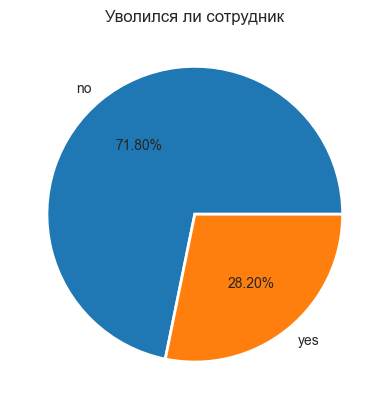

In [79]:
quit_train = train_quit['quit'].value_counts()
plt.pie(quit_train, labels=quit_train.index, autopct='%1.2f%%', wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'})
plt.title('Уволился ли сотрудник')

plt.show()

За прошедший период из компании уволилась почти треть сотрудников.

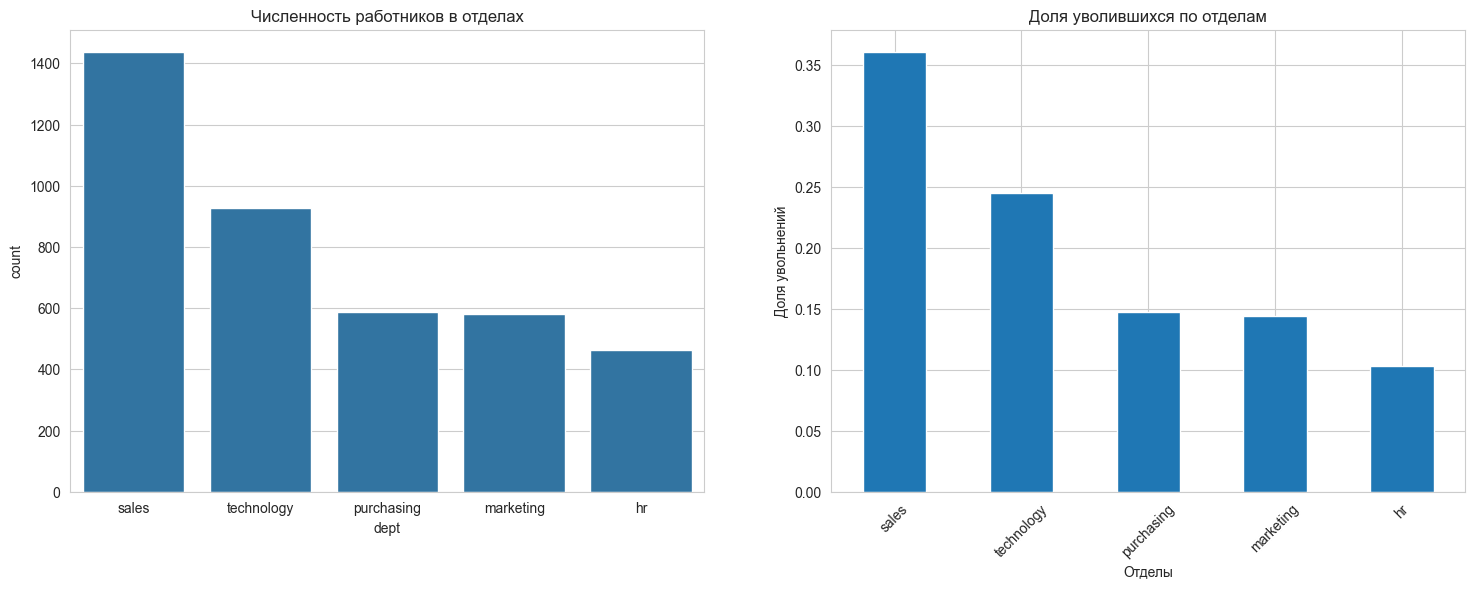

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='dept', data=train_quit, order=dept_order, ax=axes[0])
axes[0].set_title('Численность работников в отделах') 

rel = t['dept'].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title('Доля уволившихся по отделам')
axes[1].set_xlabel('Отделы')
axes[1].set_ylabel('Доля увольнений')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.show()

В целом доля уволившихся соответствует размеру отдела.

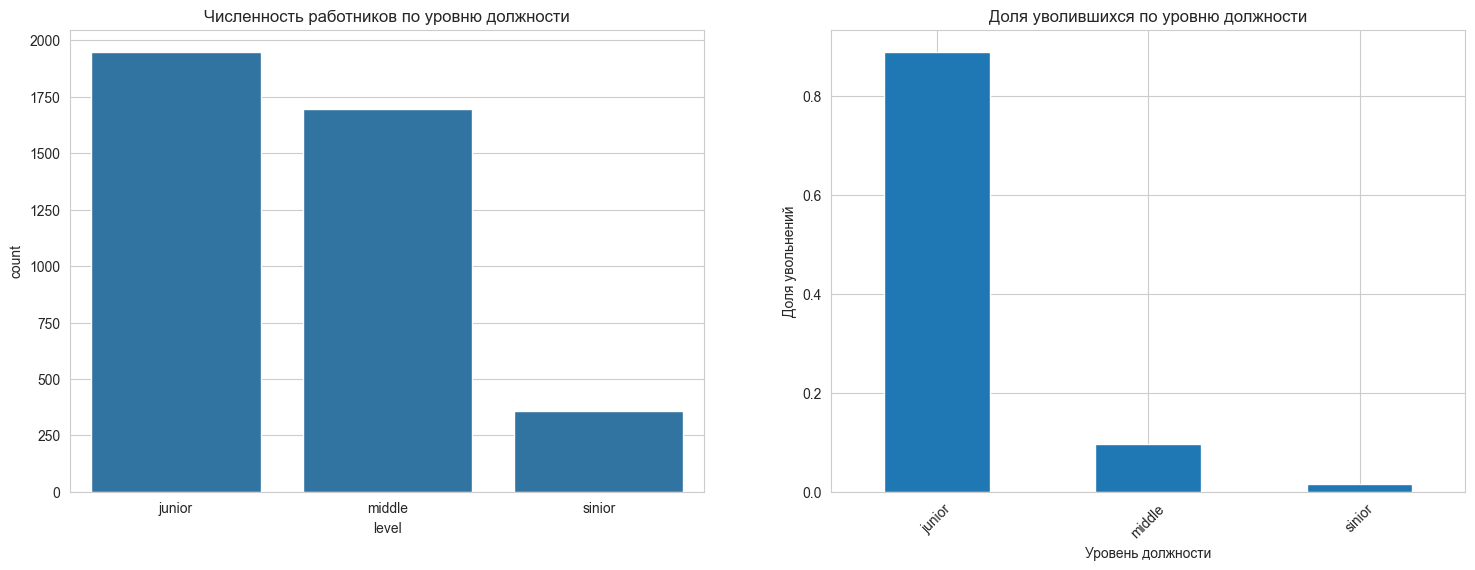

In [83]:
order_level = ['junior', 'middle', 'sinior']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='level', data=train_quit, order=order_level, ax=axes[0])
axes[0].set_title('Численность работников по уровню должности') 

rel = t['level'].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title('Доля уволившихся по уровню должности')
axes[1].set_xlabel('Уровень должности')
axes[1].set_ylabel('Доля увольнений')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.show()

Больше всего в компании новичков. И так же больше всего уволилось с позиции новичка.

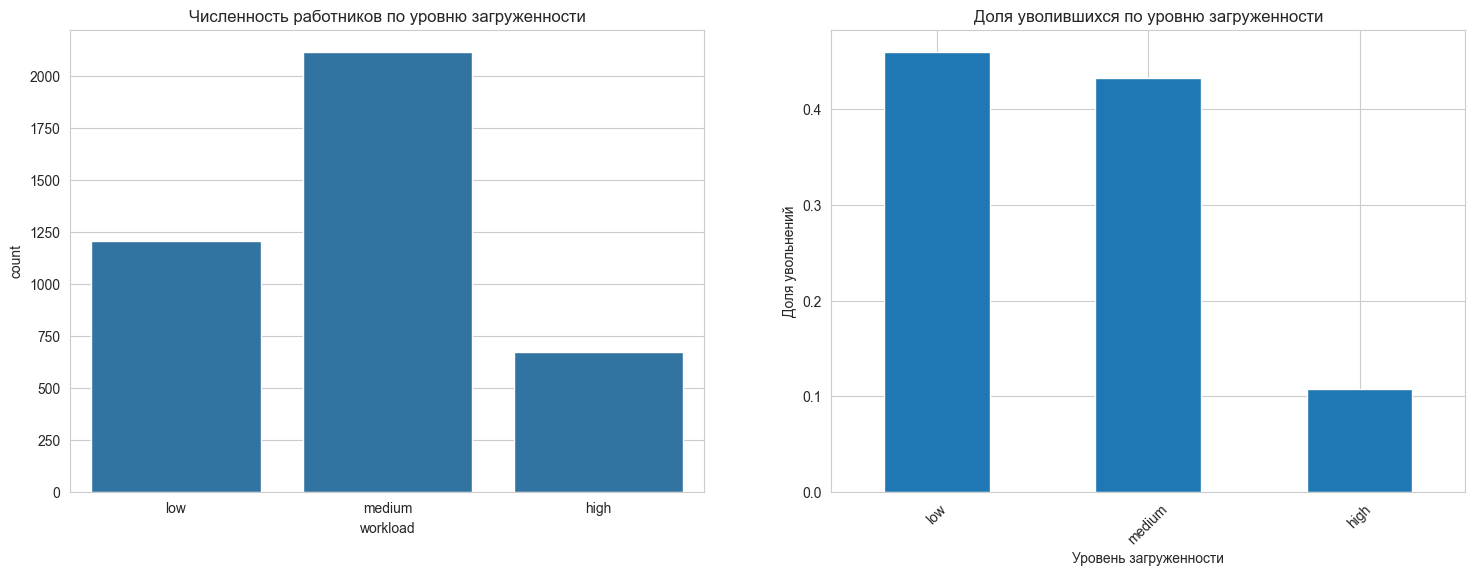

In [85]:
order_work = ['low', 'medium', 'high']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='workload', data=train_quit, order=order_work, ax=axes[0])
axes[0].set_title('Численность работников по уровню загруженности') 

rel = t['workload'].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title('Доля уволившихся по уровню загруженности')
axes[1].set_xlabel('Уровень загруженности')
axes[1].set_ylabel('Доля увольнений')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.show()

Больше всего сотрудники увольняются с низкой загрузки.

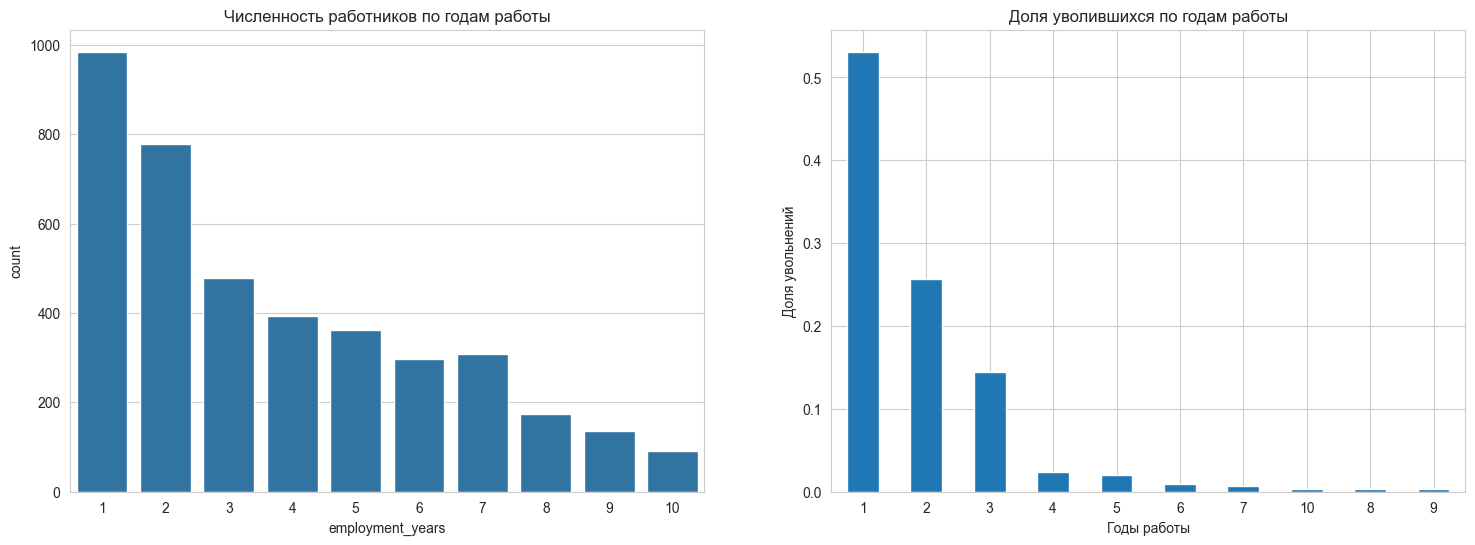

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='employment_years', data=train_quit, ax=axes[0])
axes[0].set_title('Численность работников по годам работы') 

rel = t['employment_years'].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title('Доля уволившихся по годам работы')
axes[1].set_xlabel('Годы работы')
axes[1].set_ylabel('Доля увольнений')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.show()

Очень большая доля увольнений наблюдается у сотрудников с 1 по 3 год работы.

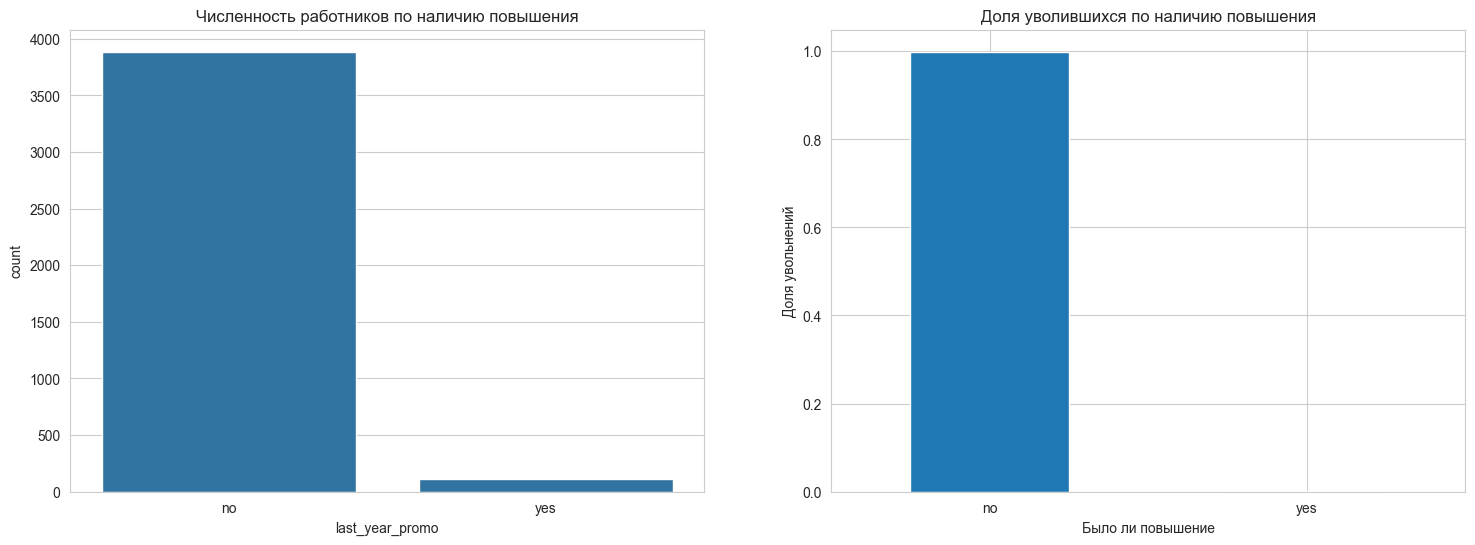

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='last_year_promo', data=train_quit, ax=axes[0])
axes[0].set_title('Численность работников по наличию повышения') 

rel = t['last_year_promo'].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title('Доля уволившихся по наличию повышения')
axes[1].set_xlabel('Было ли повышение')
axes[1].set_ylabel('Доля увольнений')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.show()

Из тех у кого было повышение не уволился никто. При этом в компании очень маленькая доля повышений.

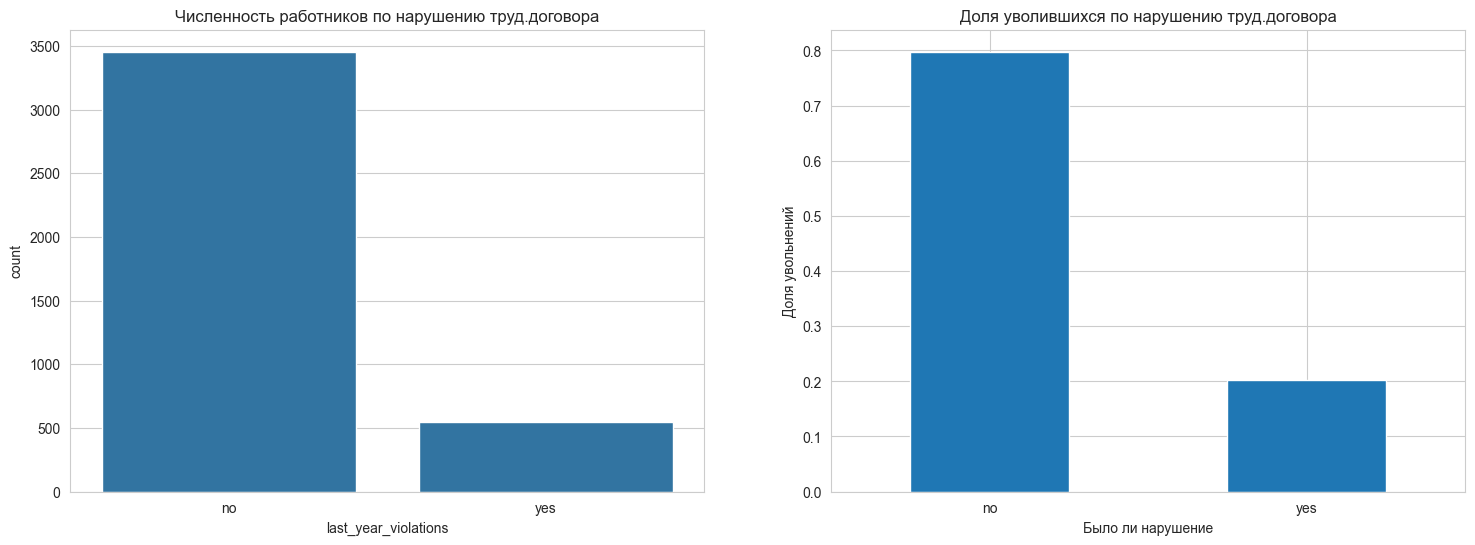

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='last_year_violations', data=train_quit, ax=axes[0])
axes[0].set_title('Численность работников по нарушению труд.договора') 

rel = t['last_year_violations'].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title('Доля уволившихся по нарушению труд.договора')
axes[1].set_xlabel('Было ли нарушение')
axes[1].set_ylabel('Доля увольнений')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.show()

Больше всех уволилось из тех, кто не нарушал трудовой договор.

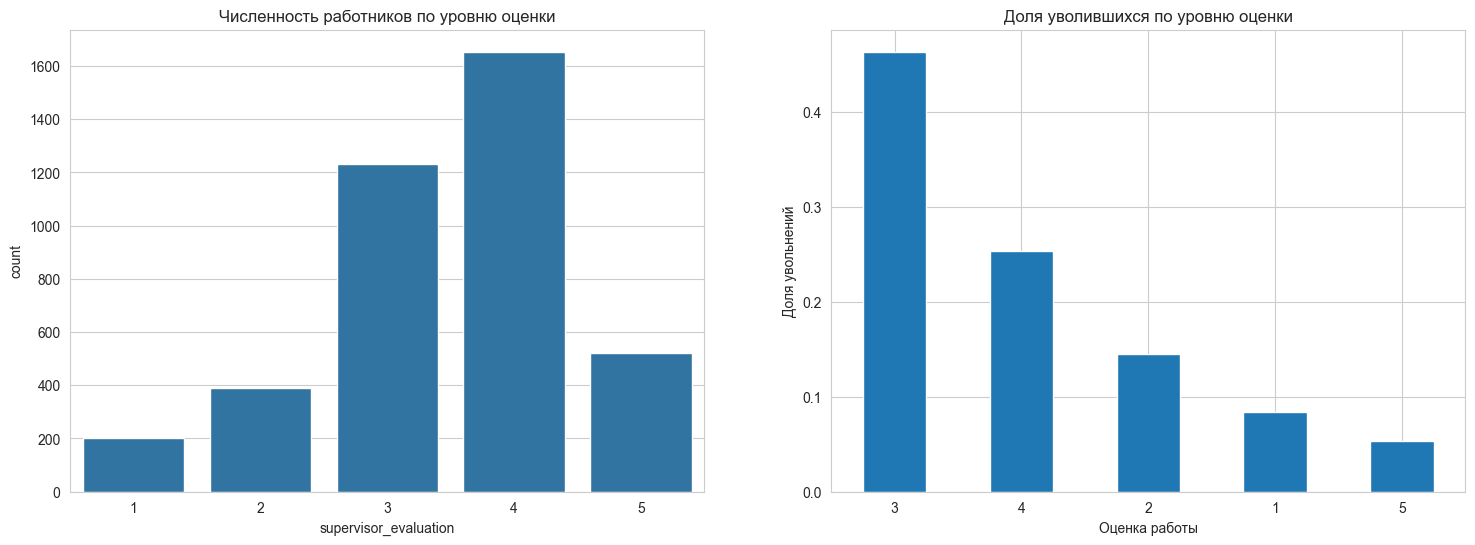

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.countplot(x='supervisor_evaluation', data=train_quit, ax=axes[0])
axes[0].set_title('Численность работников по уровню оценки') 

rel = t['supervisor_evaluation'].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title('Доля уволившихся по уровню оценки')
axes[1].set_xlabel('Оценка работы')
axes[1].set_ylabel('Доля увольнений')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.show()

Больше всего уволилось работников с оценкой 3.

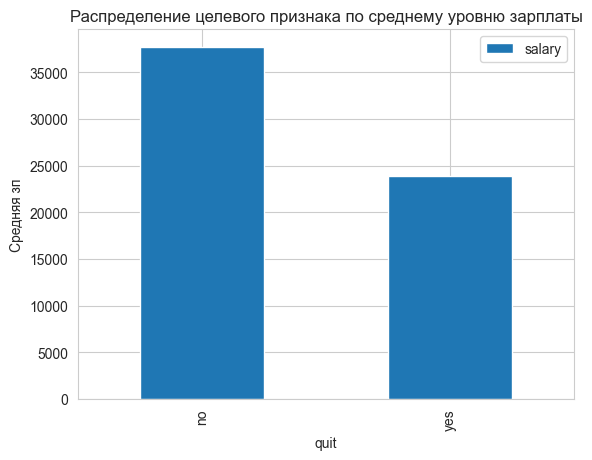

In [95]:
sa = train_quit.pivot_table(values='salary', index='quit').plot(kind='bar')
plt.title('Распределение целевого признака по среднему уровню зарплаты')
plt.ylabel('Средняя зп')
plt.show()

Заработная плата у тех, кто уволился меньше, чем у тех, кто остался.

In [97]:
# Добавление таргета из первой задачи в тестовую выборку второй
test_2_target = test_features.join(target_quit, on='id').join(target_job, on='id')

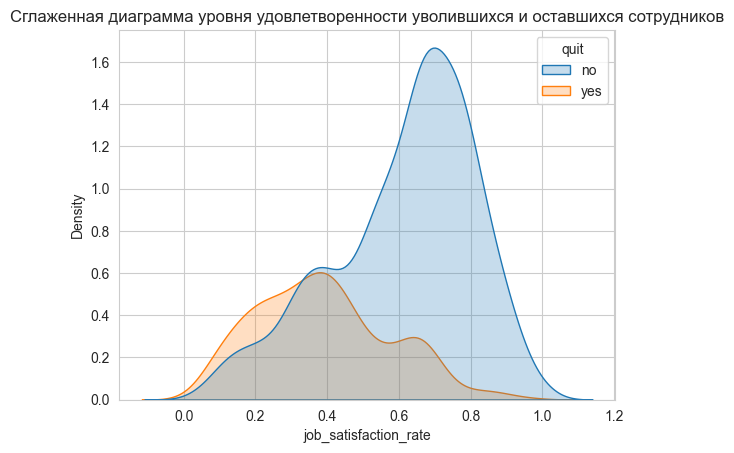

In [98]:
sns.kdeplot(data=test_2_target, x='job_satisfaction_rate', hue='quit', fill=True)
plt.title('Сглаженная диаграмма уровня удовлетворенности уволившихся и оставшихся сотрудников')
plt.show()

Уровень удовлетворенности уволившихся сотрудников намного меньше чем у тех, кто остался.

**Итоги раздела:**
1. Портрет типичного `"уволившегося сотрудника"`: работает на позиции `Junior`, имеет `низкий уровень` загруженности, рабоатет в компании `1-3 года` и `не имел повышение` в последнее время, скорее всего `нарушал трудовой договор` и имеет `оценку работы от 1 до 3`, а так же имеет `низкий уровень удовлетворенности`.

### Шаг. Добавление нового входного признака

In [102]:
# Создание датафрейма для предсказания признака
new_job = train_quit.drop('quit', axis=1)

In [103]:
# Получение предсказания
pred_job = best_model.predict(new_job)

In [104]:
# Создание датафрейма с верными индексами
pred_job = pd.DataFrame(pred_job, train_quit.index)

In [105]:
# Добавление в датафрейм для второй задачи нового столбца с предсказанным таргетом первой
train_quit['job_satisfaction_rate'] = pred_job

In [106]:
pred_job_f = best_model.predict(test_features)
pred_job_f = pd.DataFrame(pred_job_f, test_features.index)
test_features['job_satisfaction_rate'] = pred_job_f

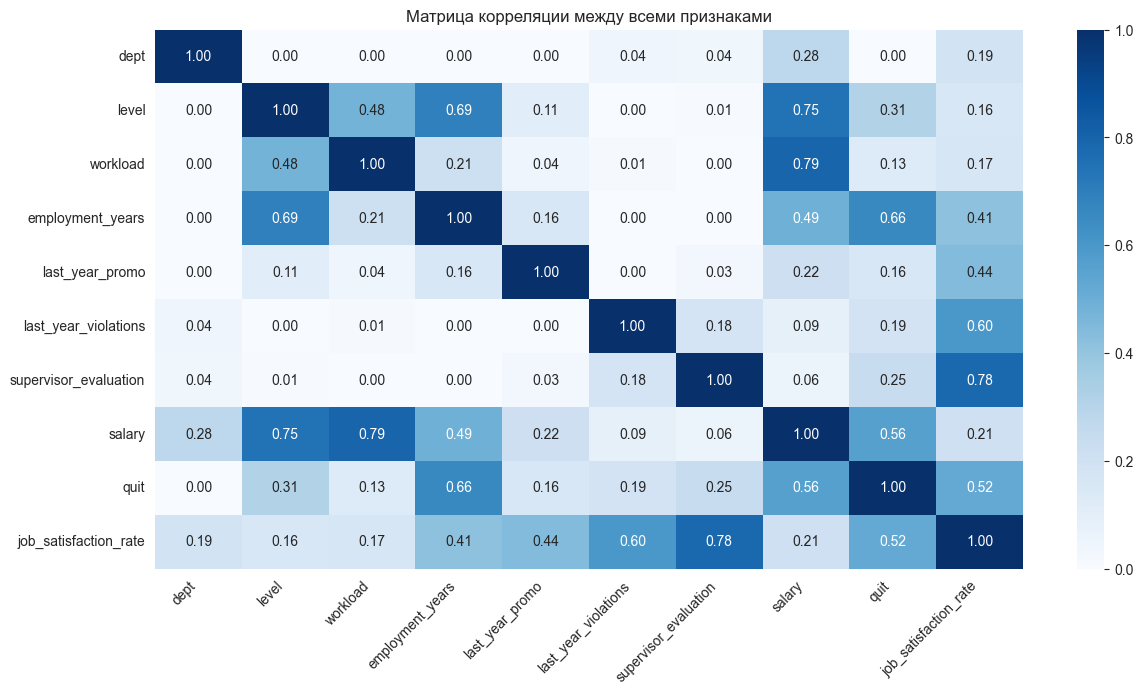

In [107]:
corr_df_2 = train_quit.phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
plt.figure(figsize=(14,7))
heatmap = sns.heatmap(corr_df_2, annot=True, cmap='Blues', fmt='.2f')
plt.title('Матрица корреляции между всеми признаками')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.show()

* Новый входной признак `job_satisfaction_rate` в целом имеет хорошую кореляцию со всеми признаками, в том числе и с целевым, значит был добавлен не зря.

**Итоги раздела:**
1. В датафрейм с признаками для второй задачи `all_df_2` был добавлен новый признак `job_satisfaction_rate`, который был предсказан с помощью лучшей модели из первой задачи.
2. Построена матрица корреляции между всеми признаками.
3. Новый признак `job_satisfaction_rate` в целом имеет хорошую кореляцию со всеми признаками, в том числе и с целевым.

### Шаг. Подготовка данных

In [111]:
test_quit = test_features.join(target_quit, on='id')
test_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.872000,no
686555,hr,junior,medium,1,no,no,4,30000,0.668621,no
467458,sales,middle,low,5,no,no,4,19200,0.657143,no
418655,sales,middle,low,6,no,no,4,19200,0.655000,no
789145,hr,middle,medium,5,no,no,5,40800,0.824127,no


In [112]:
# Дополнение пайплайна предобработки кодированием признаков
X_train = train_quit.drop('quit', axis=1)
X_test = test_quit.drop('quit', axis=1)
y_train = train_quit['quit']
y_test = test_quit['quit']

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [113]:
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

ohe_pipe = Pipeline(
    [(
        'simpleImputer',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ohe',
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    )]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['no', 'yes']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median'))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

**Итоги раздела:**
1. Данные были разделены на выборки с использованием стратификации по целевому признаку.
2. Пайплан обработки пропусков был дополнен кодированием признаков.

### Шаг. Обучение модели

In [116]:
X_train_preprocessed = data_preprocessor.fit_transform(X_train)

smote = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X_train_preprocessed, y_train)

final_pipeline = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1')],
        'models__C': range(1, 5),
    },
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            probability=True)],
        'models__C': range(1, 15),
        'models__gamma': range(1, 15),
    }
]

randomized_search = RandomizedSearchCV(
    final_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_resampled, y_resampled)

X_test_preprocessed = data_preprocessor.transform(X_test)

y_pred = randomized_search.best_estimator_.predict_proba(X_test_preprocessed)

In [117]:
best_model = randomized_search.best_estimator_
'Лучшая модель и её параметры:', best_model

('Лучшая модель и её параметры:',
 Pipeline(steps=[('models',
                  DecisionTreeClassifier(max_depth=6, max_features=16,
                                         random_state=42))]))

In [118]:
'Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_

('Метрика лучшей модели на кросс-валидации:', 0.9522482112571901)

In [119]:
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
f'Метрика ROC-AUC на тестовой выборке: {roc_auc}'

'Метрика ROC-AUC на тестовой выборке: 0.9214234032675477'

### Шаг. Промежуточные выводы

1. Лучшей оказалась модель `DecisionTreeClassifier` с гиперпараметрами `max_depth=6`, `max_features=16`.
2. Метрика ROC-AUC лучшей модели на кросс-валидации: 0.95.
3. Метрика ROC-AUC на тестовой выборке: 0.92.

## Общий вывод

### В этом проекте я проделала следующую работу:

1. Загрузила и изучила данные из 5 датафреймов `train_job`, `test_features`, `test_target`, `train_quit`, `target_quit`.
2. Выполнила предобработку данных: удалила пустые значения категорий в столбцах `dept` и `workload`, пропуски обработала в пайплайне.
3. Для удобства обработки и подготовки данных датафреймы для каждой задачи были объединены в один общий `all_df` и `all_df_2`.
4. Для каждой задачи был проведён исследовательский анализ данных, рассмотрено распределение целевых признаков в констексте входных.
5. Пайплайн предобработки данных был дополнен масштабированием и кодированием входных и целевого признаков.
6. Построила матрицу корреляции для всех признаков методом `phik`.
7. Написала и рассчитала собственную метрику `SMAPE` для задачи регрессии.
8. С помощью пайплайна с использованием моделей `DecisionTreeRegressor`, `LinearRegression`, `KNeighborsRegressor`, `SVR` и подбором гиперпараметров была определена лучшая модель для предсказания уровня удовлетворенности сотрудников.
9. Для второй задачи был предсказан с помощью модели из первой задачи новый входной признак `job_satisfaction_rate`. Он был добавлен во входные признаки.
10. Для второй задачи классификации в апйплайне с использованием моделей `DecisionTreeClassifier`, `LogisticRegression`, `KNeighborsClassifier`, `SVC` и побором гиперпараметров была определена лучшая модель.
11. Для лучшей модели классификации рассчитана метрика `ROC-AUC`.

### На основании проделанной работы можно сделать следующие выводы:
* **Для задачи 1:**
  * Распределение целевого признака для задачи регрессии имеет два пика в районе 0.4 и 0.7.
  * Целевой признак имеет равномерное распределение между входными признаками: `Dept`, `Level`,` Workload`.
  * Работники с высокой заработной платой имеют высокий уровень удовлетворенности.
  * Уровень удовлетворенности сотрудников резко проседает на 3, 4 и 10 годах работы.
  * У работников, имевших повышение, более высокий уровень удовлетворенности.
  * Нарушение трудового договора негативно сказывается на уровне удволетворенности сотрудника.
  * Работники с оценками 4 и 5 имеют более выской уровень удовлетворенности.
  * Целевой признак `job_satisfaction_rate` слабо коррелирует со входными признаками.
  * Лучшей оказалась модель `DecisionTreeRegressor` с гиперпараетрами `max_depth=13`, `max_features=16`.
  * Метрика SMAPE лучшей модели на кросс-валидации 14.96, на тестовой выборке 14.3.
* **Для задачи 2:**
  * Портрет типичного `"уволившегося сотрудника"`: работает на позиции `Junior`, имеет `низкий уровень` загруженности, рабоатет в компании `1-3 года` и `не имел повышение` в последнее время, скорее всего `нарушал трудовой договор` и имеет `оценку работы от 1 до 3`, а так же имеет `низкий уровень удовлетворенности`.
  * Новый входной признак `job_satisfaction_rate` в целом имеет хорошую кореляцию со всеми признаками.
  * Лучшей оказалась модель `DecisionTreeClassifier` с гиперпараметрами `max_depth=6`, `max_features=16`.
  * Метрика ROC-AUC лучшей модели на кросс-валидации: 0.95.
  * Метрика ROC-AUC на тестовой выборке: 0.92.

### Рекомендации:
1. Для повышения уровня удволетворенности сотрудников следует внимательнее присмотреться к сотрудникам, отработавшим 3, 4 и 10 лет, так как именно в этот период происходит снижение этого уровня. Возможно таким сотрудникам стоит предложить повышение, так как исходя из данных исследовательского анализа в компании ничтожно маленькое кол-во повышений.


2. Так же компании стоит пересмотреть свою систему выговоров, так как нарушение работником трудового договора так же сильно влияет на уровень удовлетворенности. Например стоит еще раз напомнить работникам о том, какие правила есть в договоре. Так же возможно улучшит ситуацию введние устных или письменных предупреждений, вместо того, чтобы сразу же выносить работнику взыскание.


3. В контексте удержания сотрудников фокус внимания следует обратить на новеньких, чей стаж в компании не более 3-х лет, у кого ещё не было повышений и имеющих низкую оценку работы. Таких сотрудников можно попытаться мотивировать, провести тренинг, напомнить о цели компании и личном вкладе каждого сотрудника. Так же исправить ситуацию может индивидуальное развитие сотрудников, например корпоративные курсы повышения квалификации, так как новичкам может не хватать компетенций и из-за этого они могут чувствовать себя неуверенно.